In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [ ]:
!pip install --quiet pytorch_lightning 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import pytorch_lightning
from torchvision import transforms
import torch.utils.data
from torch.utils.data import DataLoader
from torch.autograd import Variable

from datetime import datetime
import time
import math

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Training')
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N', # 1 for test, 10 for train
                    help='number of epochs to train')
parser.add_argument('--num-classes', default=10,
                    help='number of classes in the input dataset')
#parser.add_argument('--lr', type=float, default=0.0002, metavar='LR',
#                    help='learning rate')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                     help='learning rate')  # cascade version, original = 0.01
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--random', default=True,
                    help='random initialization for PGD')
# FGSM: num-steps:1 step-size:0.1099   PGD-20: num-steps:20 step-size:0.005495
parser.add_argument('--epsilon', default=0.1099, # matters for region
                    help='perturbation')
parser.add_argument('--num-steps', default=20,
                    help='perturb number of steps, FGSM: 1, PGD-20: 20')
parser.add_argument('--step-size', default=0.005495,
                    help='perturb step size, FGSM: 0.1099, PGD-20: 0.005495') # change from 0.1099 to 0.005495 3/12/2021

args = parser.parse_args(args=[])
# Device setup
if args.no_cuda:
	device = torch.device("cpu")
else:
	device = torch.device("cuda:0")

In [ ]:
print(device)

cuda:0


In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [ ]:
import pickle

In [ ]:
!pip install --quiet captum

In [ ]:
import matplotlib.pyplot as plt

# cifar

In [ ]:
# CIFAR-10 data
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(train_set, batch_size=args.batch_size,  shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        #x = x.reshape(1,3,512,1024)
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [ ]:
def eval_testX(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    idx = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            #print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            idx += 1

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
alex = AlexNet().to(device)

In [ ]:
def train_alex(model):
	model = model.to(device)
 
	for epoch in range(1, args.epochs+1):
		start_time = time.time()
		sgd = optim.SGD(model.parameters(), lr=args.lr)
  
		trainX(args, model, device, train_loader, sgd, epoch)

		trnloss, trnacc = eval_testX(model, device, train_loader)

		print('Epoch ' + str(epoch) + ': ' + str(int(time.time() - start_time)) + 's', end=', ')
		print('trn_loss: {:.4f}, trn_acc: {:.2f}%'.format(trnloss, 100. * trnacc), end='\n')

	return model

In [ ]:
from IPython.utils.path import target_update
def trainX(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # clear gradients
        optimizer.zero_grad()

        loss = F.cross_entropy(model(data), target)

        # get gradients and update
        loss.backward()
        optimizer.step()

In [ ]:
alex = train_alex(alex)
alex.eval()

Epoch 1: 14s, trn_loss: 1.2315, trn_acc: 54.88%
Epoch 2: 13s, trn_loss: 1.1831, trn_acc: 56.20%
Epoch 3: 13s, trn_loss: 1.0706, trn_acc: 61.89%
Epoch 4: 13s, trn_loss: 1.0515, trn_acc: 62.02%
Epoch 5: 15s, trn_loss: 0.9748, trn_acc: 65.10%
Epoch 6: 14s, trn_loss: 0.8088, trn_acc: 70.88%
Epoch 7: 14s, trn_loss: 0.7561, trn_acc: 73.15%
Epoch 8: 13s, trn_loss: 0.6585, trn_acc: 76.39%
Epoch 9: 13s, trn_loss: 0.5770, trn_acc: 79.85%
Epoch 10: 13s, trn_loss: 0.4737, trn_acc: 83.32%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
#torch.save(alex.state_dict(), "/content/drive/MyDrive/FYP/alex3.3.pt")

In [ ]:
#alex.load_state_dict(torch.load('/content/drive/MyDrive/FYP/alex3.3.pt'))

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
saliency = IntegratedGradients(alex)

label = []
sample = train_set[0]

for data, target in train_loader:
  #print(target)
  data, target = data.to(device), target.to(device)
  attribution = saliency.attribute(data, target=target)
  label.append(attribution)

In [ ]:
from captum.attr import LRP

In [ ]:
lrpa = LRP(alex)

lrp = []

for data, target in train_loader:
  data, target = data.to(device), target.to(device)
  attribution = lrpa.attribute(data, target=target)
  lrp.append(attribution)

In [ ]:
import random

In [ ]:
def mute(a=.5, b=.5, thr=.5):
  """
  random mutation on weight
  """
  rand = random.random()
  a = rand
  b = 1-a
  if rand<thr:
    #print('mute')
    a = 1-a
    b = 1-b
  #print('a:', a, 'b:', b)
  return (a,b)

lbl = []

#importance mask
for i in range(len(lrp)):
  a, b = mute()
  with torch.no_grad():
    lbl.append(torch.ones_like(lrp[i])-(b*F.normalize(lrp[i])+a*label[i]))

In [ ]:
def pgd_whitebox(bi, model, X, mask, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device):

	X_pgd = Variable(X.data, requires_grad=True)
	# print(X_pgd.shape)
	# region = Variable(region.data, requires_grad=True)
 
	if args.random:
		#noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device) 
		noise = torch.clamp(mask, -epsilon, epsilon).to(device) # XAI mask
		X_pgd = Variable(X_pgd.data + noise, requires_grad=True)
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			#print('m',model(X_pgd).shape)
			#print('y',y.shape)
			loss = F.cross_entropy(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		#print('r', region.shape)
		# print(region.grad.data)

		eta = torch.clamp(mask, -step_size, step_size) * X_pgd.grad.data.sign() #grad for patch only # XAI mask based pixel wise step size
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)
	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')
	return X_pgd

In [ ]:
def pgd_whitebox0(bi, model, X, y, epsilon=args.epsilon, num_stpes=args.num_steps, step_size=args.step_size, device=device, cifar=False):
	out = model(X)
	X_pgd = Variable(X.data, requires_grad=True)
	if args.random:
		random_noise = torch.FloatTensor(*X_pgd.shape).uniform_(-epsilon, epsilon).to(device)
		X_pgd = Variable(X_pgd.data + random_noise, requires_grad=True)
  
	st = time.time()
	lss = []
	for _ in range(args.num_steps):
		opt = optim.SGD([X_pgd], lr=1e-3)
		opt.zero_grad()

		with torch.enable_grad():
			loss = nn.CrossEntropyLoss()(model(X_pgd), y)
			lss.append(loss.item())
		loss.backward()
		eta = step_size * X_pgd.grad.data.sign()
		X_pgd = Variable(X_pgd.data + eta, requires_grad=True)
		eta = torch.clamp(X_pgd.data - X.data, -epsilon, epsilon)
		X_pgd = Variable(X.data + eta, requires_grad=True)
		X_pgd = Variable(torch.clamp(X_pgd, 0, 1.0), requires_grad=True)

	et = time.time()
	print('pgd time: ', et-st, ' s')
	st = [i for i in range(20)]
	plt.plot(st, lss)
	#if not bi: plt.imsave('2.png', X_pgd.view(X_pgd.shape[0],28,28)[0,:,:].cpu(), cmap='gray')

	return X_pgd

In [ ]:
def pgd_eval_adv_test(device, test_loader):

    alex.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            print(batch_idx)
            data, target = data.to(device), target.to(device)

            #data = data.view(data.size(0), 28 * 28)
            adv_data = pgd_whitebox0(batch_idx, alex, data, target, device=device)

            output = alex(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

0
pgd time:  0.0740058422088623  s
0 misclassified: 128
1
pgd time:  0.07313895225524902  s
1 misclassified: 128
2
pgd time:  0.07216286659240723  s
2 misclassified: 128
3
pgd time:  0.07108163833618164  s
3 misclassified: 128
4
pgd time:  0.07707738876342773  s
4 misclassified: 128
5
pgd time:  0.063079833984375  s
5 misclassified: 128
6
pgd time:  0.0689699649810791  s
6 misclassified: 128
7
pgd time:  0.07559514045715332  s
7 misclassified: 128
8
pgd time:  0.07203960418701172  s
8 misclassified: 128
9
pgd time:  0.06635022163391113  s
9 misclassified: 128
10
pgd time:  0.06483721733093262  s
10 misclassified: 128
11
pgd time:  0.06479144096374512  s
11 misclassified: 128
12
pgd time:  0.0659031867980957  s
12 misclassified: 128
13
pgd time:  0.07537841796875  s
13 misclassified: 128
14
pgd time:  0.07531619071960449  s
14 misclassified: 128
15
pgd time:  0.0766599178314209  s
15 misclassified: 128
16
pgd time:  0.0741569995880127  s
16 misclassified: 128
17
pgd time:  0.07566380500

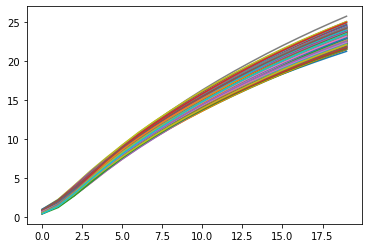

In [ ]:
advloss, advacc = pgd_eval_adv_test(device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
def lbl_eval_adv_test(mask, device, test_loader):

    alex.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            #data = data.view(data.size(0), 28*28)
            adv_data = pgd_whitebox(batch_idx, alex, data, mask[batch_idx].to(torch.float32), target, device=device)

            #adv_data = adv_data.view(adv_data.size(0), 28*28)
            output = alex(adv_data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            print(batch_idx, 'misclassified:', args.batch_size-pred.eq(target.view_as(pred)).sum().item())
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy

pgd time:  0.07132387161254883  s
0 misclassified: 128
pgd time:  0.06983757019042969  s
1 misclassified: 128
pgd time:  0.0670461654663086  s
2 misclassified: 128
pgd time:  0.0647878646850586  s
3 misclassified: 128
pgd time:  0.07103657722473145  s
4 misclassified: 128
pgd time:  0.07095217704772949  s
5 misclassified: 128
pgd time:  0.0713036060333252  s
6 misclassified: 128
pgd time:  0.07029891014099121  s
7 misclassified: 128
pgd time:  0.07196903228759766  s
8 misclassified: 128
pgd time:  0.0699467658996582  s
9 misclassified: 128
pgd time:  0.07049918174743652  s
10 misclassified: 128
pgd time:  0.07120299339294434  s
11 misclassified: 128
pgd time:  0.06980156898498535  s
12 misclassified: 128
pgd time:  0.07007265090942383  s
13 misclassified: 128
pgd time:  0.0758063793182373  s
14 misclassified: 128
pgd time:  0.07057046890258789  s
15 misclassified: 128
pgd time:  0.0629415512084961  s
16 misclassified: 128
pgd time:  0.06264996528625488  s
17 misclassified: 128
pgd time

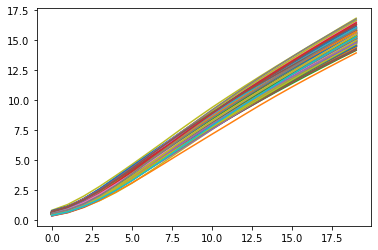

In [ ]:
advloss, advacc = lbl_eval_adv_test(lbl, device, test_loader) # train or test
print('test_loss: {:.4f}, test_acc: {:.2f}%'.format(advloss, 100. * advacc), end=', ')

In [ ]:
saliency = IntegratedGradients(alex)

audit1 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox0(idx+1, alex, data, target)
  attribution = saliency.attribute(adv_data, target=target)
  audit1.append(attribution)

In [ ]:
saliency = IntegratedGradients(fnn)

audit2 = []
sample = train_set[0]

for idx, (data, target) in enumerate(train_loader):
  data, target = data.to(device), target.to(device)
  data = data.view(data.size(0), 28 * 28)
  adv_data = pgd_whitebox(idx+1, fnn, data, mask[idx], target, device=device)
  attribution = saliency.attribute(adv_data, target=target)
  audit2.append(attribution)

In [ ]:
#@title XAI(data vs PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit1[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.8745, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
#@title XAI(data vs gene-mean(LRP-IG) PGD)
sim = 0
for i in range(len(label)):
  sim += torch.mean(nn.CosineSimilarity()(label[i], audit3[i]))

mean = sim/float(len(label))
print(mean)

tensor(0.9807, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


# CIFAR benchmark

In [ ]:
!pip install --quiet torchattacks

In [ ]:
import torchattacks

In [ ]:
atk = torchattacks.SparseFool(alex)
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
      data, target = data.to(device), target.to(device)
      atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
      adv_data = atk(data, target)
      saliency = IntegratedGradients(alex)
      audit1 = saliency.attribute(adv_data, target=target)

- Save progress: 100.00 % / Robust accuracy: 11.72 % / L2: 0.00000 (347.498 it/s) 	


In [ ]:
#@title XAI Monitor(data vs SparseFool)
sim = nn.CosineSimilarity()(label[0], audit1)
sim = torch.nan_to_num(sim)
print(torch.mean(sim))

tensor(0.8917, device='cuda:0', dtype=torch.float64)


In [ ]:
atk = torchattacks.SINIFGSM(alex, steps=20)
audit1 = []
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    atk.save(data_loader=[(data, target)], save_path="_transfer.pt")
    adv_data = atk(data, target)
    saliency = IntegratedGradients(alex)
    audit1.append(saliency.attribute(adv_data, target=target))

- Save progress: 100.00 % / Robust accuracy: 11.72 % / L2: 1.66370 (0.988 it/s) 	


In [ ]:
#@title XAI Monitor(data vs SINIFGSM)
sim = nn.CosineSimilarity()(label[0], audit1)
sim = torch.nan_to_num(sim)
print(torch.mean(sim))

tensor(0.6571, device='cuda:0', dtype=torch.float64)


torch.Size([3, 32, 32])


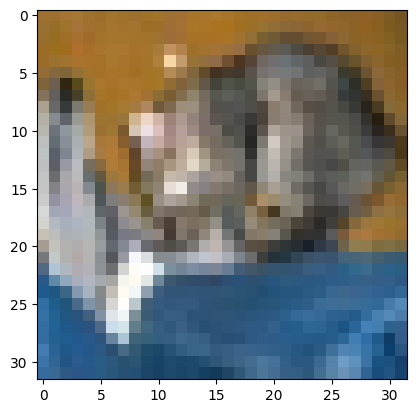

In [ ]:
#@title Sample
for batch_idx, (data, target) in enumerate(test_loader):
  if not batch_idx:
    print(data[0].shape)
    plt.imshow(transforms.ToPILImage()(data[0]))

# No need to train